Analyse de patients atteints de cancer du sein dans un dataset hospitalier

In [30]:
#Importation des bibliothèques
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, ttest_ind, f_oneway
!pip install lifelines
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test


from google.colab import files



In [2]:
#Téléchargement du fichier CSV dans Google Colab
uploaded = files.upload()

#Chargement du fichier CSV dans un DataFrame pandas
df = pd.read_csv(next(iter(uploaded)))


Saving SEER_Breast_Cancer_Dataset.csv to SEER_Breast_Cancer_Dataset.csv


In [3]:
#Aperçu des premières lignes
print("Aperçu des premières lignes :")
print(df.head())

#Dimensions et types de colonnes
print("\nDimensions du DataFrame :")
print(df.shape)

print("\nTypes des colonnes :")
print(df.dtypes)




Aperçu des premières lignes :
   Age                                              Race   \
0   43  Other (American Indian/AK Native, Asian/Pacifi...   
1   47  Other (American Indian/AK Native, Asian/Pacifi...   
2   67                                              White   
3   46                                              White   
4   63                                              White   

                   Marital Status  Unnamed: 3 T Stage  N Stage 6th Stage  \
0  Married (including common law)         NaN       T2      N3      IIIC   
1  Married (including common law)         NaN       T2      N2      IIIA   
2  Married (including common law)         NaN       T2      N1       IIB   
3                        Divorced         NaN       T1      N1       IIA   
4  Married (including common law)         NaN       T2      N2      IIIA   

                                 Grade   A Stage  Tumor Size Estrogen Status  \
0  Moderately differentiated; Grade II  Regional          40      

In [4]:
#Valeurs manquantes
print("\nValeurs manquantes par colonne :")
print(df.isnull().sum().sort_values(ascending=False))




Valeurs manquantes par colonne :
Unnamed: 3                4024
Age                          0
Race                         0
Marital Status               0
T Stage                      0
N Stage                      0
6th Stage                    0
Grade                        0
A Stage                      0
Tumor Size                   0
Estrogen Status              0
Progesterone Status          0
Regional Node Examined       0
Reginol Node Positive        0
Survival Months              0
Status                       0
dtype: int64


In [5]:
#Suppression de la colonne vide 'Unnamed: 3'
df = df.drop(columns=['Unnamed: 3'], errors='ignore')

#Suppression des doublons
df = df.drop_duplicates()

#Vérification
print("Colonnes restantes :", df.columns)

Colonnes restantes : Index(['Age', 'Race ', 'Marital Status', 'T Stage ', 'N Stage', '6th Stage',
       'Grade', 'A Stage', 'Tumor Size', 'Estrogen Status',
       'Progesterone Status', 'Regional Node Examined',
       'Reginol Node Positive', 'Survival Months', 'Status'],
      dtype='object')


In [6]:
#Imputation des valeurs manquantes
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(include='object').columns

#Imputation des colonnes numériques par la médiane
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

#Imputation des colonnes catégorielles par la valeur la plus fréquente (mode)
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [7]:
#Statistiques descriptives
print("\nStatistiques descriptives pour les colonnes numériques :")
print(df.describe())

print("\nStatistiques descriptives pour les colonnes catégorielles :")
print(df.describe(include='object'))


Statistiques descriptives pour les colonnes numériques :
               Age   Tumor Size  Regional Node Examined  \
count  4023.000000  4023.000000             4023.000000   
mean     53.969923    30.477007               14.358439   
std       8.963118    21.121253                8.100241   
min      30.000000     1.000000                1.000000   
25%      47.000000    16.000000                9.000000   
50%      54.000000    25.000000               14.000000   
75%      61.000000    38.000000               19.000000   
max      69.000000   140.000000               61.000000   

       Reginol Node Positive  Survival Months  
count            4023.000000      4023.000000  
mean                4.158837        71.301765  
std                 5.109724        22.923009  
min                 1.000000         1.000000  
25%                 1.000000        56.000000  
50%                 2.000000        73.000000  
75%                 5.000000        90.000000  
max                46.0000

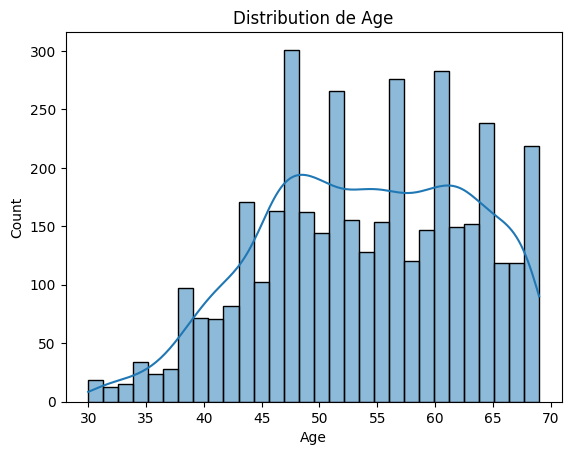

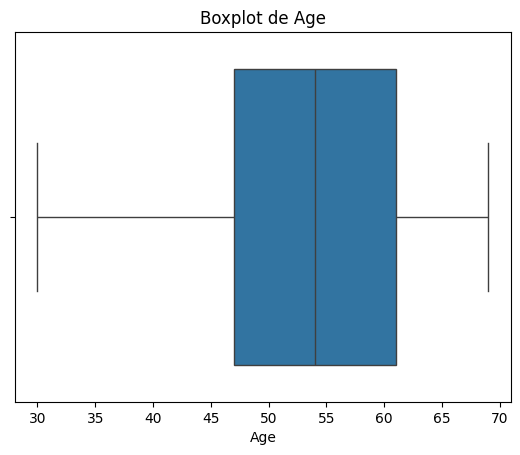

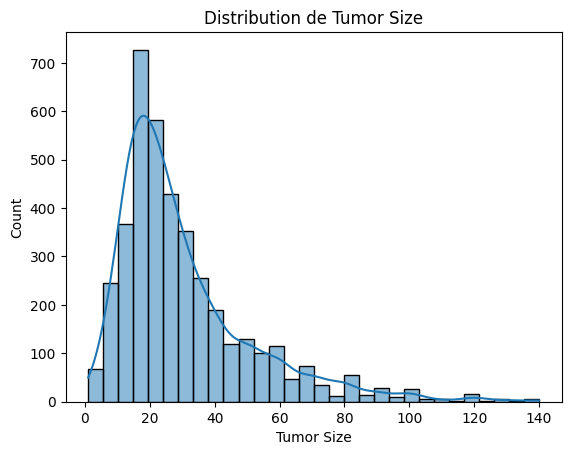

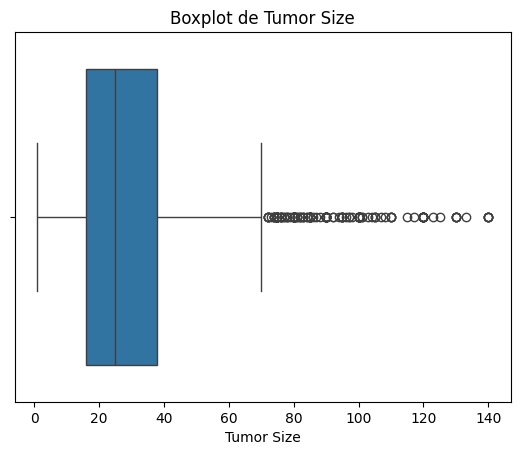

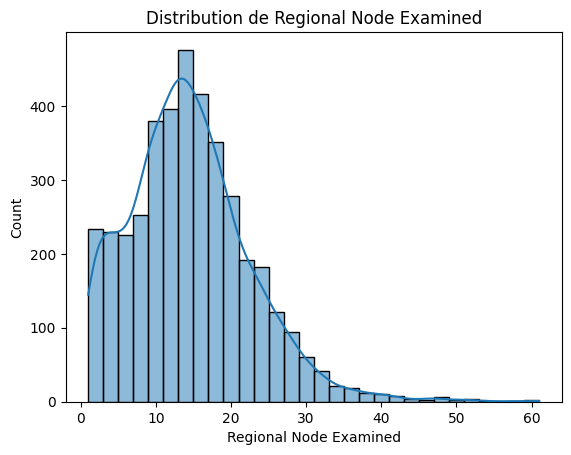

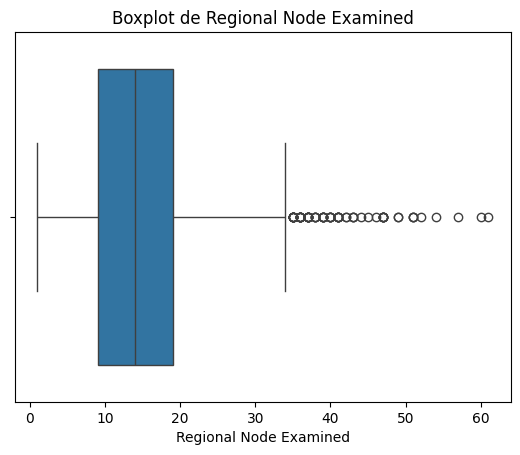

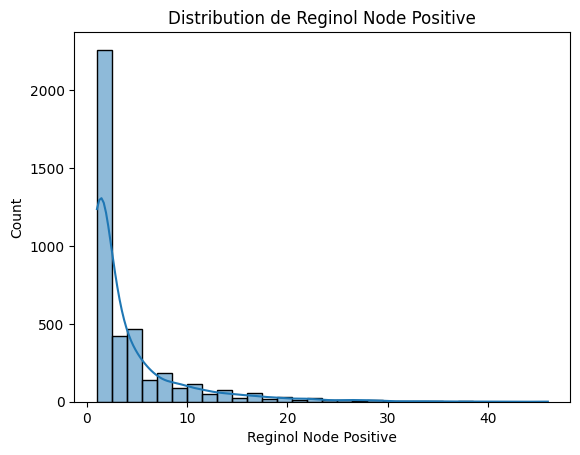

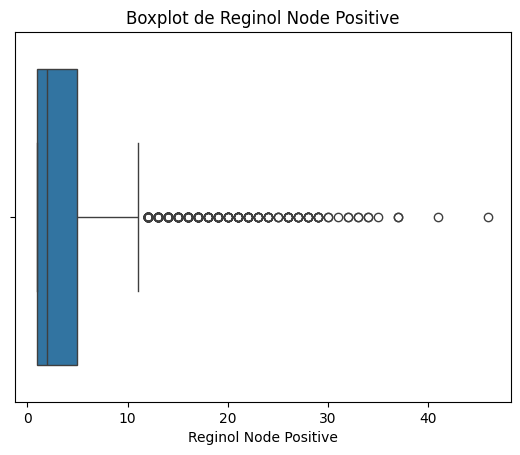

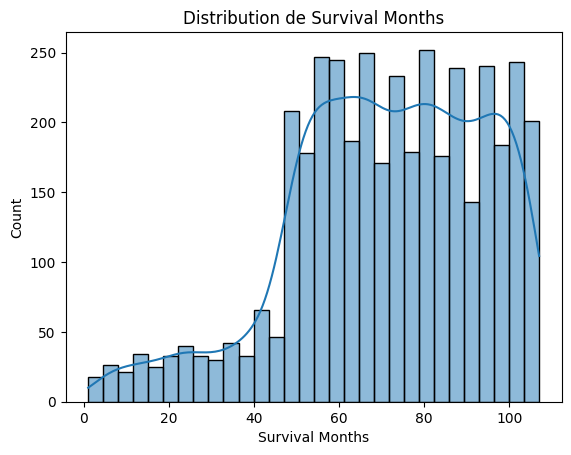

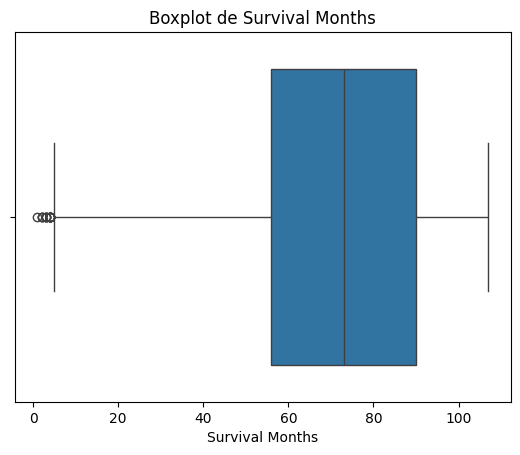

In [8]:
#Visualisation des variables numériques (Histogrammes et Boxplots)
for col in num_cols:
    plt.figure()
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution de {col}")
    plt.show()

    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot de {col}")
    plt.show()

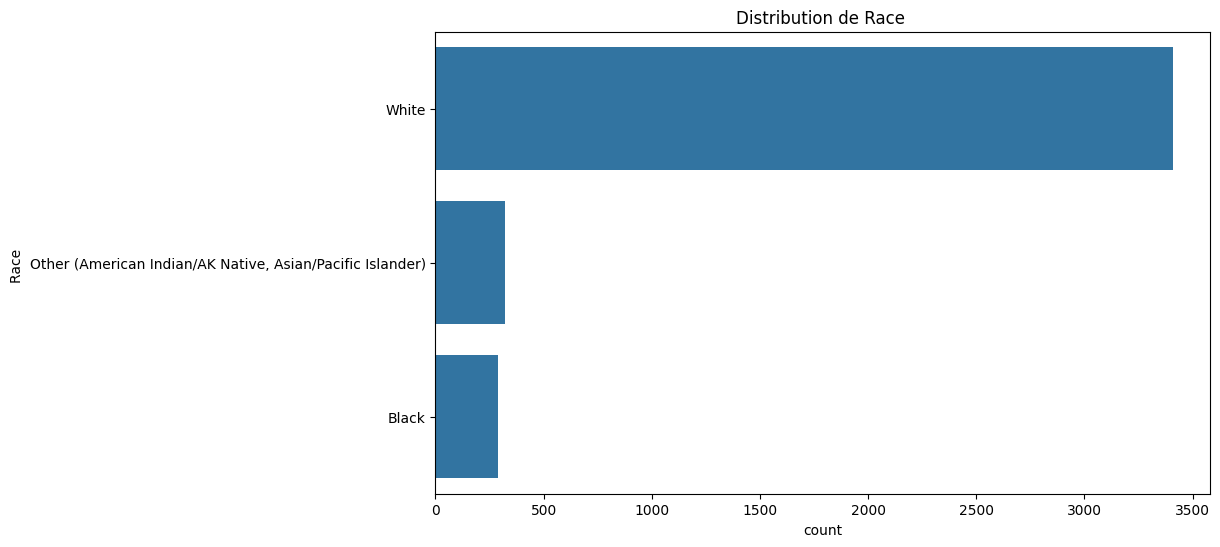

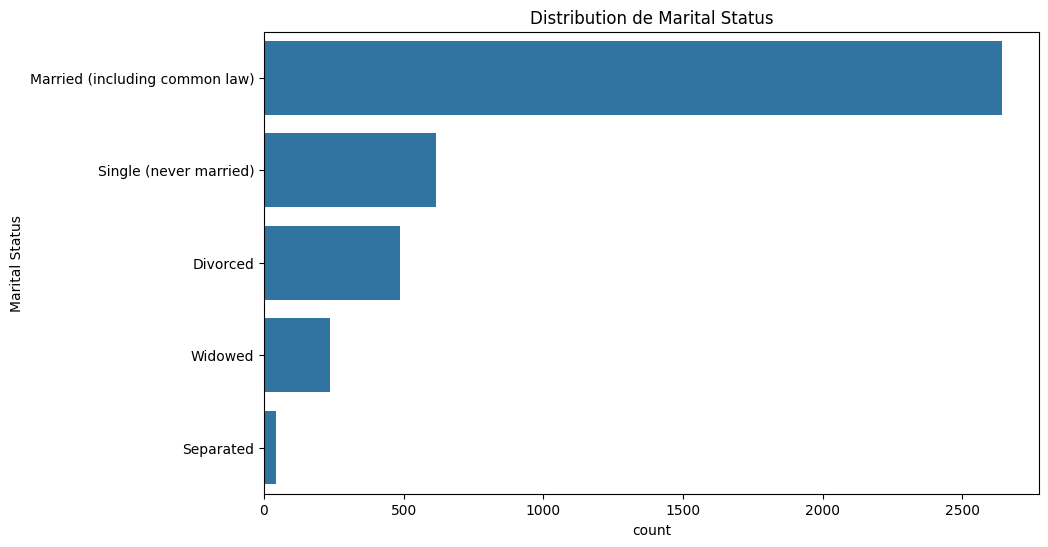

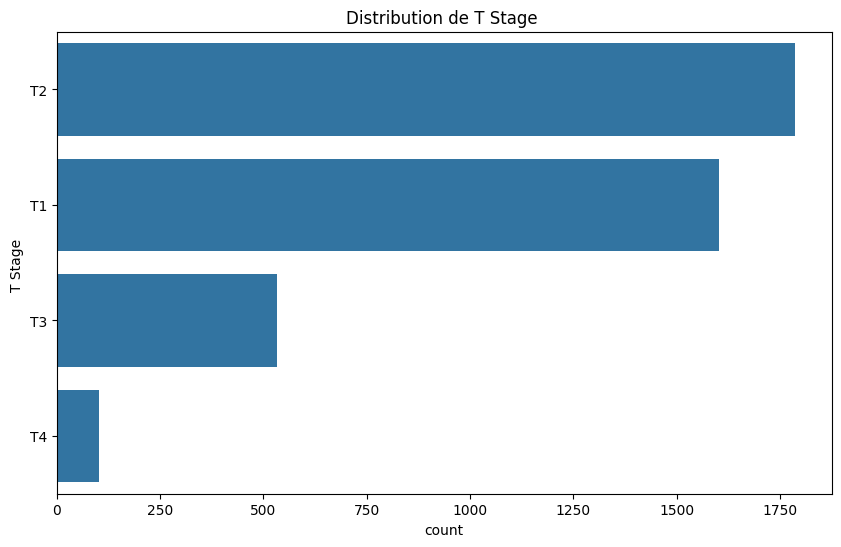

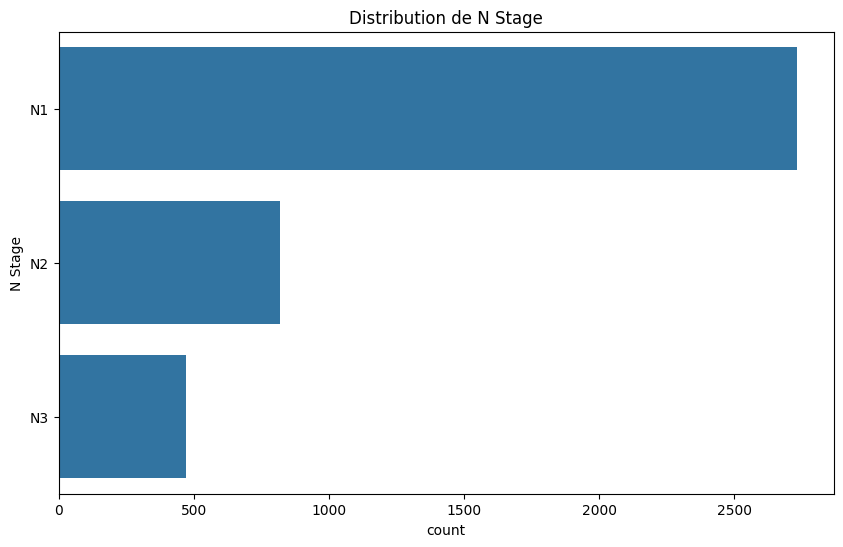

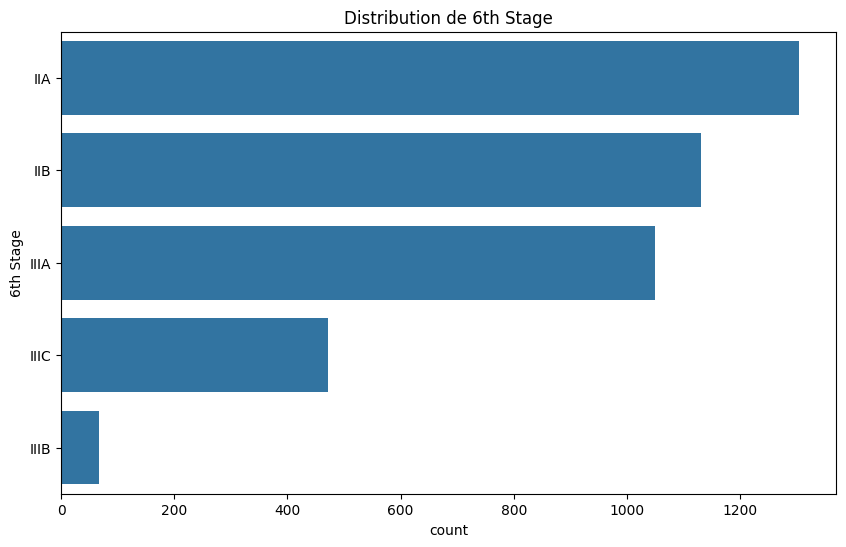

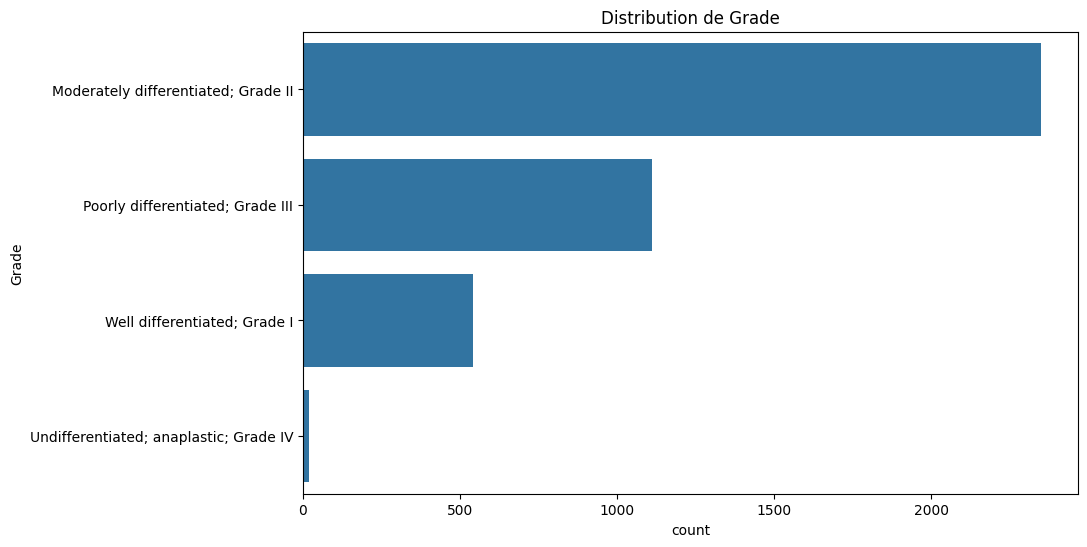

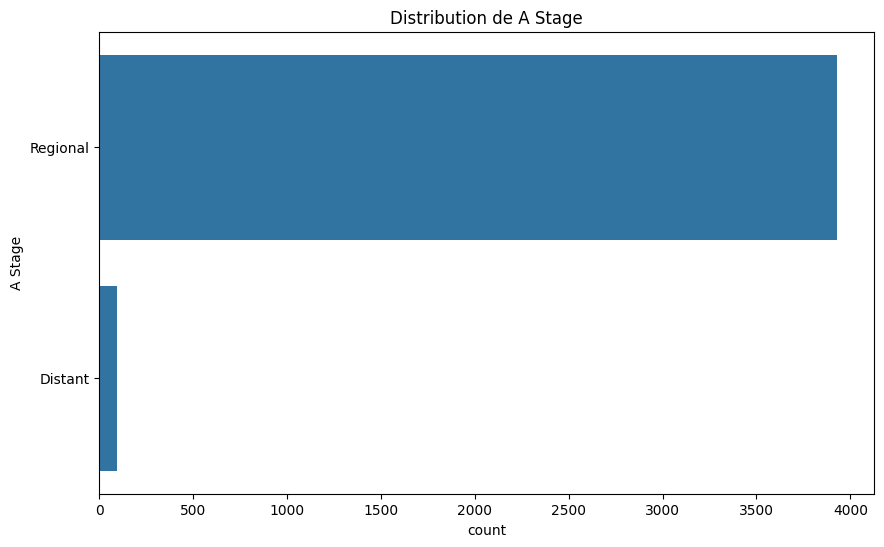

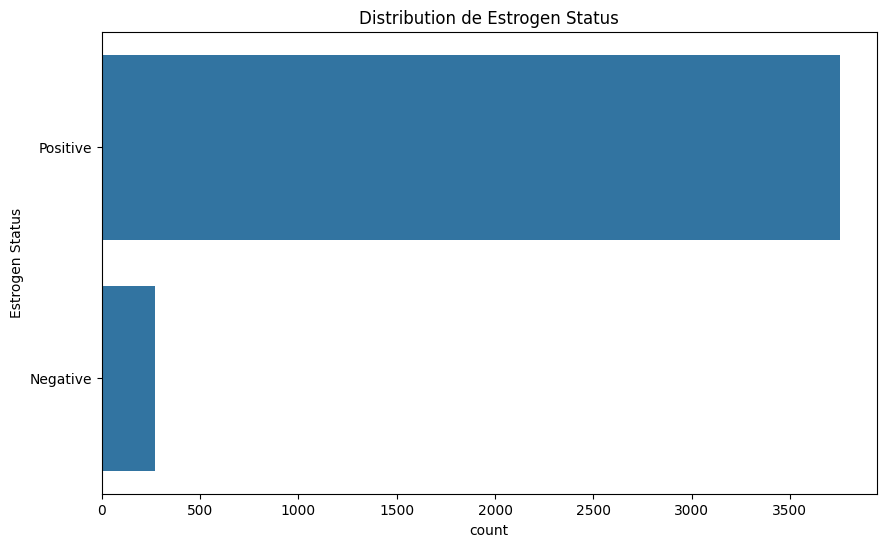

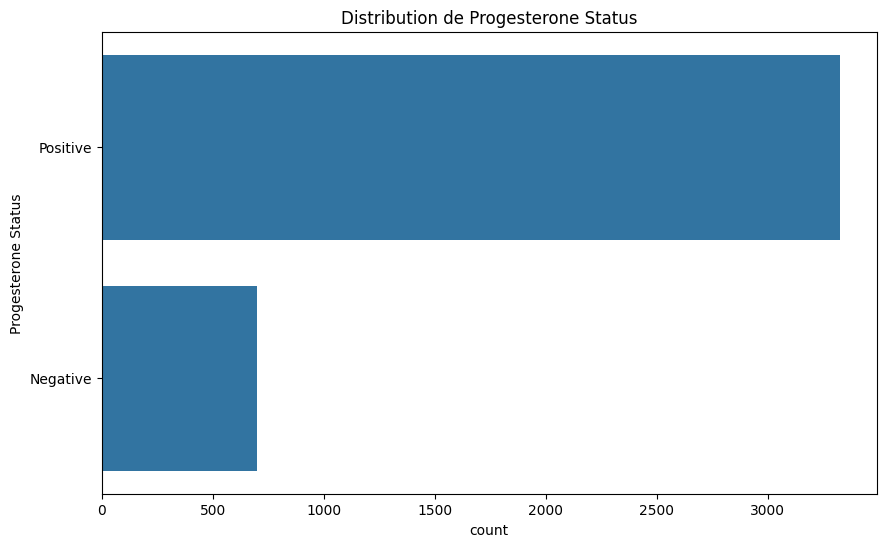

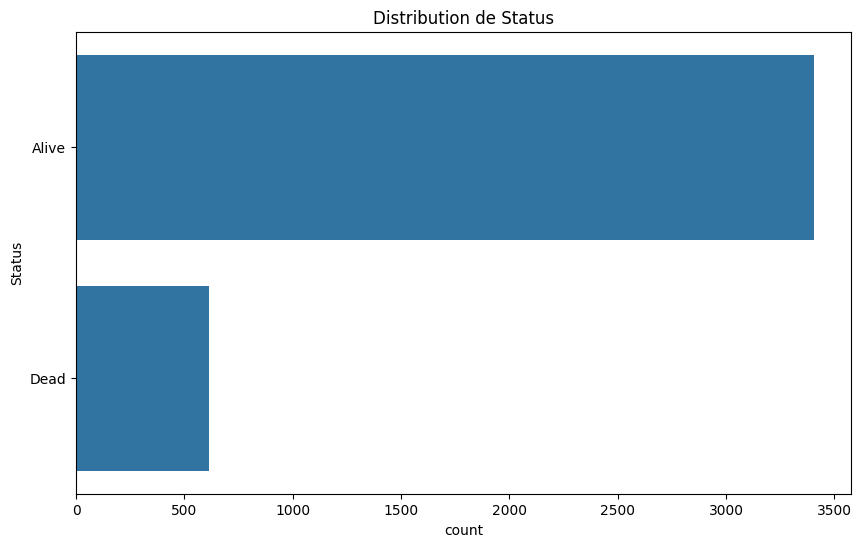

In [9]:
#Visualisation des variables catégorielles (Countplots)
for col in cat_cols:
    if df[col].nunique() < 20:  # Affichage si la colonne a moins de 20 modalités
        plt.figure(figsize=(10, 6))
        sns.countplot(y=df[col], order=df[col].value_counts().index)
        plt.title(f"Distribution de {col}")
        plt.show()

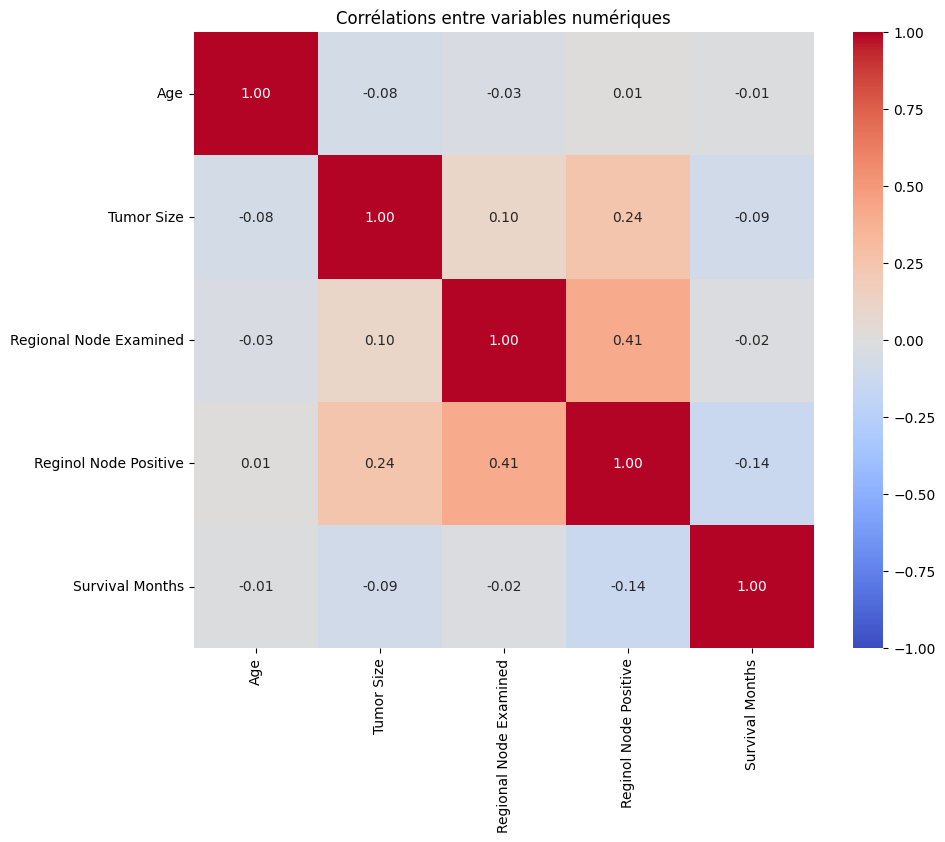

In [10]:
#Analyse des corrélations entre les variables numériques
corr = df[num_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Corrélations entre variables numériques")
plt.show()

In [11]:
#Test de Chi² entre colonnes catégorielles
for i in range(len(cat_cols)):
    for j in range(i + 1, len(cat_cols)):
        table = pd.crosstab(df[cat_cols[i]], df[cat_cols[j]])
        chi2, p, dof, ex = chi2_contingency(table)
        if p < 0.05:
            print(f"{cat_cols[i]} vs {cat_cols[j]} → p = {p:.4f}")

Race  vs Marital Status → p = 0.0000
Race  vs Grade → p = 0.0001
Race  vs Estrogen Status → p = 0.0012
Race  vs Status → p = 0.0000
Marital Status vs N Stage → p = 0.0044
Marital Status vs 6th Stage → p = 0.0314
Marital Status vs Progesterone Status → p = 0.0263
Marital Status vs Status → p = 0.0000
T Stage  vs N Stage → p = 0.0000
T Stage  vs 6th Stage → p = 0.0000
T Stage  vs Grade → p = 0.0000
T Stage  vs A Stage → p = 0.0000
T Stage  vs Estrogen Status → p = 0.0002
T Stage  vs Progesterone Status → p = 0.0033
T Stage  vs Status → p = 0.0000
N Stage vs 6th Stage → p = 0.0000
N Stage vs Grade → p = 0.0000
N Stage vs A Stage → p = 0.0000
N Stage vs Estrogen Status → p = 0.0000
N Stage vs Progesterone Status → p = 0.0000
N Stage vs Status → p = 0.0000
6th Stage vs Grade → p = 0.0000
6th Stage vs A Stage → p = 0.0000
6th Stage vs Estrogen Status → p = 0.0000
6th Stage vs Progesterone Status → p = 0.0000
6th Stage vs Status → p = 0.0000
Grade vs A Stage → p = 0.0143
Grade vs Estrogen Sta


Test t : Survival Months selon Estrogen Status → p-value = 0.0000


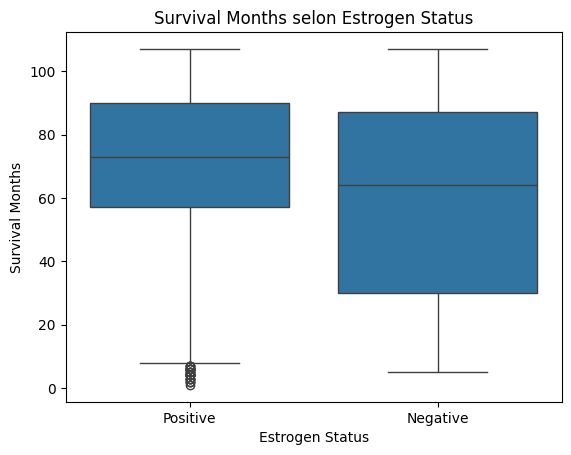


Test t : Survival Months selon Progesterone Status → p-value = 0.0000


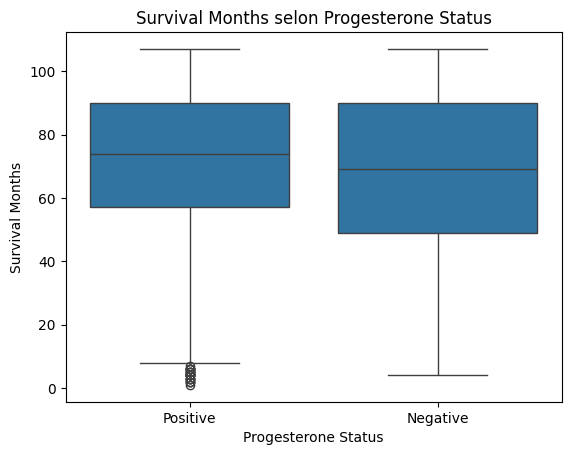

In [13]:
#Test t (comparaison entre deux groupes)

# Fonction pour sécuriser le test t
def safe_ttest(df, num_col, cat_col):
    if df[cat_col].nunique() != 2:
        print(f"\n Impossible de faire un test t : {cat_col} n'a pas 2 groupes.")
        return

    groups = df[cat_col].unique()
    g1 = df[df[cat_col] == groups[0]][num_col].dropna()
    g2 = df[df[cat_col] == groups[1]][num_col].dropna()

    if len(g1) < 2 or len(g2) < 2:
        print(f"\nÉchantillon trop petit pour {cat_col}.")
        return

    t, p = ttest_ind(g1, g2)
    print(f"\nTest t : {num_col} selon {cat_col} → p-value = {p:.4f}")

    # Boxplot visuel
    sns.boxplot(x=cat_col, y=num_col, data=df)
    plt.title(f"{num_col} selon {cat_col}")
    plt.show()

# Test t sur la survie selon Estrogen Status
safe_ttest(df, "Survival Months", "Estrogen Status")
safe_ttest(df, "Survival Months", "Progesterone Status")




### ANOVA : Survival Months selon T Stage  ###
p-value = 0.0000


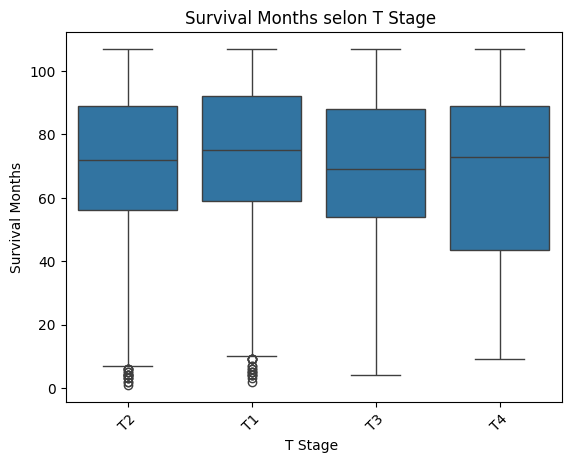


### ANOVA : Survival Months selon N Stage ###
p-value = 0.0000


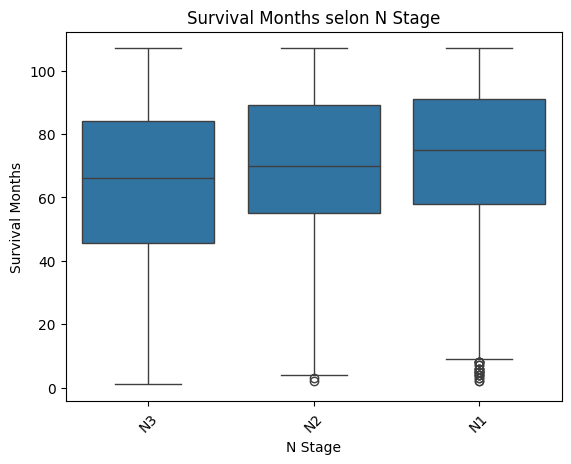


### ANOVA : Survival Months selon Grade ###
p-value = 0.0001


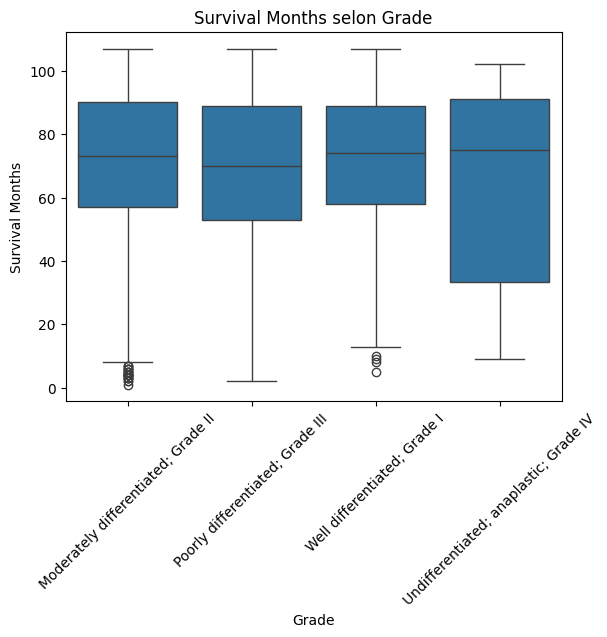

In [18]:
#Test ANOVA (comparaison entre 3 groupes ou plus)

def safe_anova(df, num_col, cat_col):
    print(f"\n### ANOVA : {num_col} selon {cat_col} ###")

    groups = df[cat_col].dropna().unique()
    if len(groups) < 3:
        print("ANOVA impossible : moins de 3 groupes.")
        return

    data_groups = [df[df[cat_col] == g][num_col].dropna() for g in groups]

    f_stat, p_val = f_oneway(*data_groups)
    print(f"p-value = {p_val:.4f}")

    # Visualisation
    sns.boxplot(x=cat_col, y=num_col, data=df)
    plt.title(f"{num_col} selon {cat_col}")
    plt.xticks(rotation=45)
    plt.show()

# ANOVA sur différents stades
safe_anova(df, "Survival Months", "T Stage ")
safe_anova(df, "Survival Months", "N Stage")
safe_anova(df, "Survival Months", "Grade")




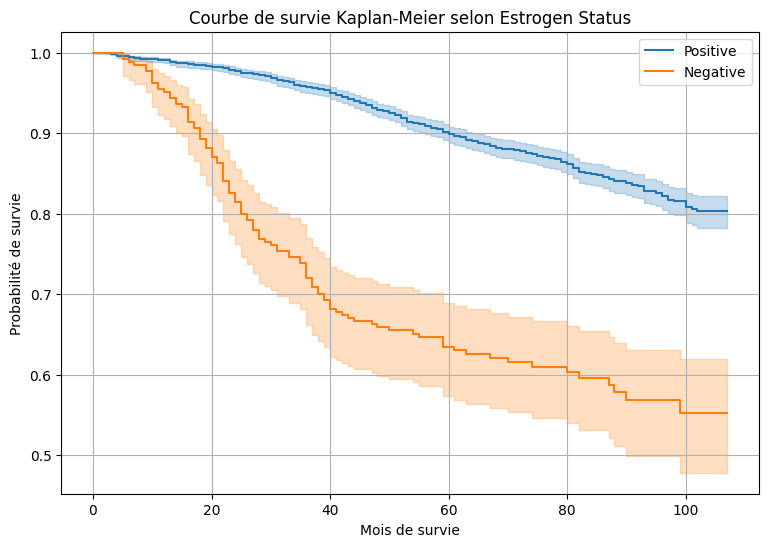

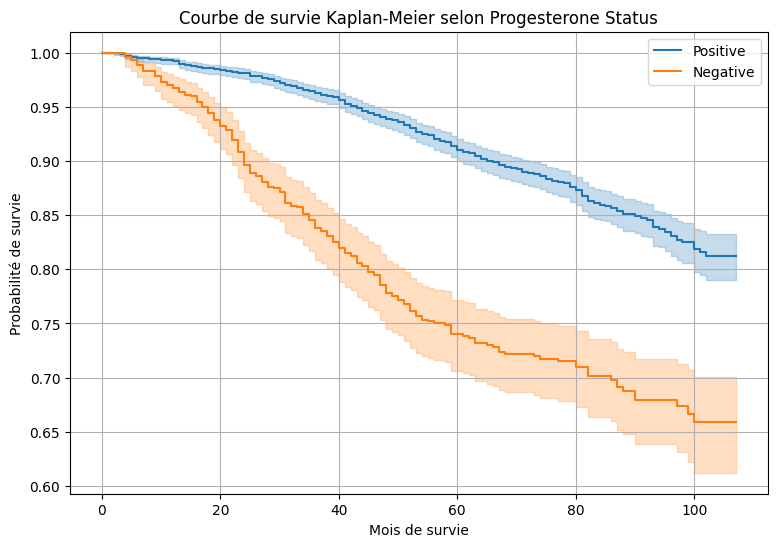

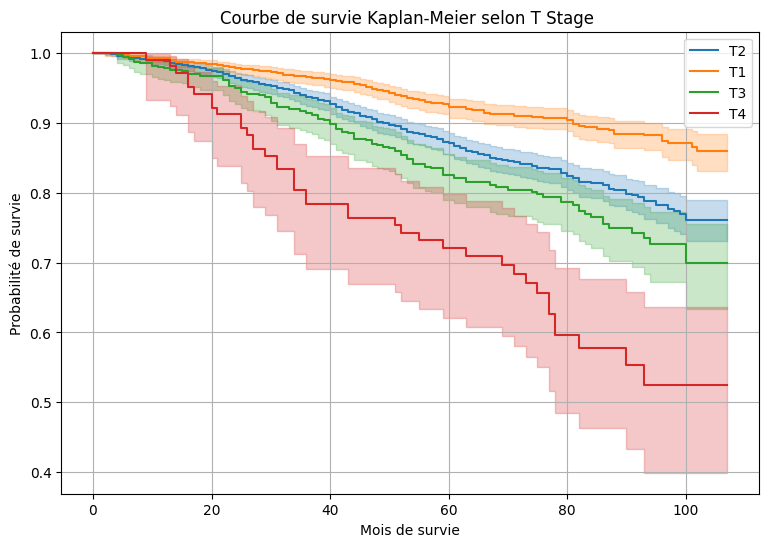

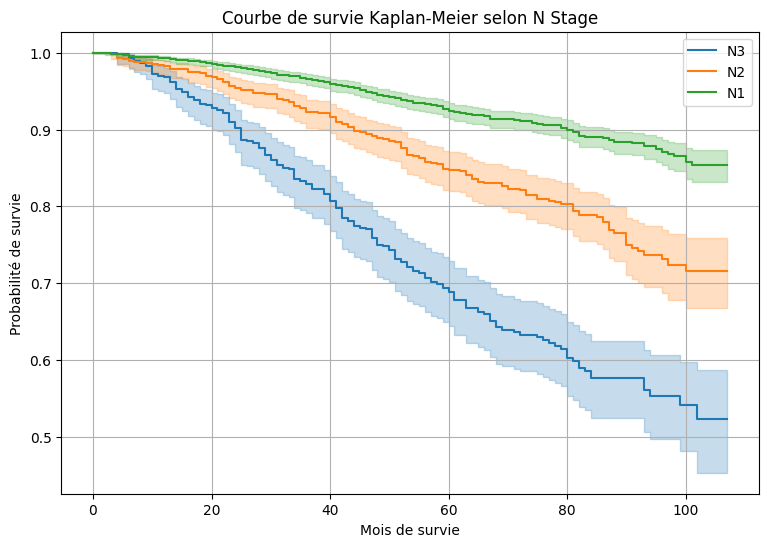

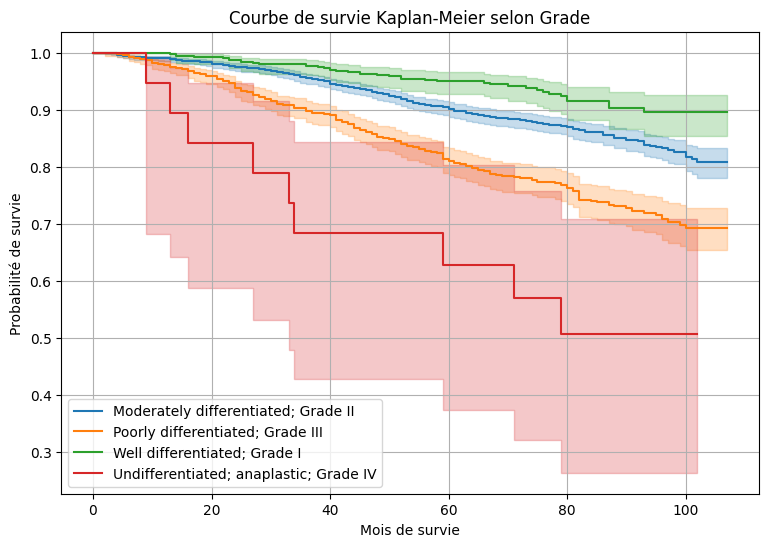

In [25]:
#Test de Kaplan Meir :estime la probabilité de survie d’un groupe de patients au fil du temps.
#Données nécessaires : survie + événement (décès/vivant) + groupe à comparer

# Création colonne event (1 = décès)
df['event'] = df['Status'].apply(lambda x: 1 if x == 'Dead' else 0)

kmf = KaplanMeierFitter()

variables_km = [
    "Estrogen Status",
    "Progesterone Status",
    "T Stage ",
    "N Stage",
    "Grade",

]

for var in variables_km:
    plt.figure(figsize=(9,6))

    for group in df[var].dropna().unique():
        subset = df[df[var] == group]
        kmf.fit(subset["Survival Months"], event_observed=subset["event"], label=str(group))
        kmf.plot()

    plt.title(f"Courbe de survie Kaplan-Meier selon {var}")
    plt.xlabel("Mois de survie")
    plt.ylabel("Probabilité de survie")
    plt.grid(True)
    plt.show()


In [27]:
# Test de Log-Rank : compare les courbes de survie kaplan-Meir de deux ou plusieurs groupes
# Ce test compare la probabilité de survie entre les groupes d’une même variable.
# Besoin d'une variable temps et d'une variable événement

variables_logrank = [
    "Estrogen Status",
    "Progesterone Status",
    "T Stage ",
    "N Stage",
    "Grade",

]

print("===== TESTS LOG-RANK =====\n")

for var in variables_logrank:
    groups = df[var].dropna().unique()

    # Seulement si au moins 2 groupes
    if len(groups) >= 2:
        # Comparaison du premier groupe avec tous les autres
        ref = groups[0]
        for other in groups[1:]:
            g1 = df[df[var] == ref]
            g2 = df[df[var] == other]

            result = logrank_test(
                g1["Survival Months"], g2["Survival Months"],
                event_observed_A=g1["event"], event_observed_B=g2["event"]
            )
            print(f"{var}: {ref} vs {other} → p-value = {result.p_value:.4f}")

print("\nFin des tests Log-Rank.")


===== TESTS LOG-RANK =====

Estrogen Status: Positive vs Negative → p-value = 0.0000
Progesterone Status: Positive vs Negative → p-value = 0.0000
T Stage : T2 vs T1 → p-value = 0.0000
T Stage : T2 vs T3 → p-value = 0.0121
T Stage : T2 vs T4 → p-value = 0.0000
N Stage: N3 vs N2 → p-value = 0.0000
N Stage: N3 vs N1 → p-value = 0.0000
Grade: Moderately differentiated; Grade II vs Poorly differentiated; Grade III → p-value = 0.0000
Grade: Moderately differentiated; Grade II vs Well differentiated; Grade I → p-value = 0.0003
Grade: Moderately differentiated; Grade II vs Undifferentiated; anaplastic; Grade IV → p-value = 0.0000

Fin des tests Log-Rank.


In [37]:
# Test de Cox : évalue l'effet de plusieurs variables simultanément sur le risque de décès (modèle multivarié)
# permet d’évaluer l’effet de toutes les variables simultanément.

# Copier le dataset
df_cox = df.copy()

# Créer la variable event
df_cox['event'] = df_cox['Status'].apply(lambda x: 1 if x == 'Dead' else 0)
df_cox = df_cox.drop(columns=['Status'])

# Nettoyer et renommer les colonnes
df_cox.columns = df_cox.columns.str.strip().str.replace(' ', '_')

# Sélection des variables pertinentes
cols = ['Survival_Months', 'event', 'Age', 'Tumor_Size',
        'Grade', 'T_Stage', 'N_Stage', 'Estrogen_Status', 'Progesterone_Status']

df_cox_model = df_cox[cols]

# Encoder uniquement les variables catégorielles pertinentes
df_cox_model = pd.get_dummies(df_cox_model, drop_first=True)

# Supprimer les colonnes constantes
df_cox_model = df_cox_model.loc[:, df_cox_model.nunique() > 1]

# Fit Cox
cox = CoxPHFitter()
cox.fit(df_cox_model, duration_col='Survival_Months', event_col='event')
cox.print_summary()


<lifelines.CoxPHFitter: fitted with 4023 total observations, 3407 right-censored observations>
             duration col = 'Survival_Months'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 4023
number of events observed = 616
   partial log-likelihood = -4702.22
         time fit was run = 2025-12-01 18:21:14 UTC

---
                                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                     
Age                                           0.02      1.02      0.00            0.01            0.03                1.01                1.03
Tumor_Size                                    0.00      1.00      0.00           -0.00            0.01                1.00                1.01
Grade_Poorly differentiated; Grade III        0.35      1.42      0.09            0.18            0.53                1.19                1.69
Grade_Undifferentiated; anaplastic; Grade IV  1.16      3.17      0.34            0.48            1.83                1.62                6.23
Grade_Well differentiated; Grade I           -0.44      0.65      0.17           -0.77           -0.10                0.46                0.90
T_Stage_T2                                    0.30      1.35      0.11            0.08            0.52                1.08                1.69
T_Stage_T3                                    0.29      1.34      0.22           -0.14            0.72                0.87                2.06
T_Stage_T4                                    0.80      2.22      0.23            0.34            1.25                1.41                3.51
N_Stage_N2                                    0.60      1.82      0.10            0.40            0.80                1.50                2.22
N_Stage_N3                                    1.17      3.22      0.10            0.97            1.37                2.63                3.93
Estrogen_Status_Positive                     -0.66      0.52      0.13           -0.92           -0.39                0.40                0.68
Progesterone_Status_Positive                 -0.50      0.61      0.11           -0.71           -0.29                0.49                0.75

                                              cmp to     z      p  -log2(p)
covariate                                                                  
Age                                             0.00  4.72 <0.005     18.70
Tumor_Size                                      0.00  1.08   0.28      1.84
Grade_Poorly differentiated; Grade III          0.00  3.95 <0.005     13.66
Grade_Undifferentiated; anaplastic; Grade IV    0.00  3.36 <0.005     10.31
Grade_Well differentiated; Grade I              0.00 -2.55   0.01      6.53
T_Stage_T2                                      0.00  2.66   0.01      7.00
T_Stage_T3                                      0.00  1.33   0.18      2.45
T_Stage_T4                                      0.00  3.43 <0.005     10.68
N_Stage_N2                                      0.00  5.94 <0.005     28.40
N_Stage_N3                                      0.00 11.42 <0.005     97.99
Estrogen_Status_Positive                        0.00 -4.90 <0.005     19.96
Progesterone_Status_Positive                    0.00 -4.72 <0.005     18.66
---
Concordance = 0.73
Partial AIC = 9428.43
log-likelihood ratio test = 433.28 on 12 df
-log2(p) of ll-ratio test = 280.62